# Wharton High School Data Science Competition
## ELO Rating Model for Basketball Team Rankings

This notebook demonstrates how to build and use an ELO rating system to rank basketball teams and predict game outcomes, following the approach outlined in the Wharton competition playbook.

## 1. Import Required Libraries

In [1]:
import sys
import importlib
import os

# IMPORTANT: Clear ALL cached modules to force fresh imports
print("Clearing module cache...")
modules_to_remove = [m for m in sys.modules.keys() if 'elo_model' in m or 'data_prep' in m or 'ensemble' in m or 'src' in m]
for module_name in modules_to_remove:
    del sys.modules[module_name]
    print(f"  Removed: {module_name}")

print(f"✓ Cleared {len(modules_to_remove)} cached modules")
print("\nNOTE: If imports still fail, use Kernel → Restart Kernel from the menu.")

Clearing module cache...
✓ Cleared 0 cached modules

NOTE: If imports still fail, use Kernel → Restart Kernel from the menu.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
import os

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import directly from modules
from elo_model import ELOModel, AdaptiveELOModel
from data_prep import DataPreprocessor, PossessionAdjustmentCalculator
from ensemble import EnsemblePredictor, create_default_ensemble, PointDifferentialModel, WinLossModel

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Explore Competition Data

We'll create sample basketball game data to demonstrate the ELO model in action.

In [3]:
# Create sample basketball game data
np.random.seed(42)

teams = ['Duke', 'North Carolina', 'Kansas', 'UCLA', 'Indiana', 'Arizona', 
         'Villanova', 'Gonzaga', 'Texas', 'Michigan', 'Notre Dame', 'Wisconsin']

# Generate sample games
games_data = []
start_date = datetime(2024, 11, 1)

for i in range(100):
    team_a = np.random.choice(teams)
    team_b = np.random.choice([t for t in teams if t != team_a])
    
    # Simulate scores (random but reasonable for basketball)
    score_a = np.random.normal(75, 8)
    score_b = np.random.normal(72, 8)
    
    games_data.append({
        'date': start_date + timedelta(days=i),
        'team_a': team_a,
        'team_b': team_b,
        'score_a': int(max(50, score_a)),
        'score_b': int(max(50, score_b)),
        'location': 'Home' if np.random.rand() > 0.5 else 'Away'
    })

games_df = pd.DataFrame(games_data)
games_df = games_df.sort_values('date').reset_index(drop=True)

print(f"Dataset: {len(games_df)} games from {games_df['date'].min().date()} to {games_df['date'].max().date()}")
print(f"\nUnique teams: {len(set(games_df['team_a'].unique()) | set(games_df['team_b'].unique()))}")
print("\nFirst 5 games:")
print(games_df.head())
print("\nData summary:")
print(games_df[['score_a', 'score_b']].describe())

Dataset: 100 games from 2024-11-01 to 2025-02-08

Unique teams: 12

First 5 games:
        date      team_a     team_b  score_a  score_b location
0 2024-11-01   Villanova       UCLA       66       74     Away
1 2024-11-02  Notre Dame  Wisconsin       77       80     Home
2 2024-11-03     Arizona    Indiana       70       67     Away
3 2024-11-04   Wisconsin   Michigan       54       79     Away
4 2024-11-05  Notre Dame   Michigan       72       70     Home

Data summary:
          score_a    score_b
count  100.000000  100.00000
mean    74.270000   71.89000
std      8.354343    7.08091
min     54.000000   55.00000
25%     68.000000   67.00000
50%     74.000000   72.00000
75%     79.000000   77.00000
max    100.000000   90.00000


## 3. Understand ELO Rating Fundamentals

The ELO rating system is a method for calculating the relative skill levels of teams based on game outcomes.

### ELO Formula

The new rating is calculated as:

$$R_{new} = R_{old} + K \times (S - E)$$

Where:
- $R_{old}$ = Team's current ELO rating
- $R_{new}$ = Team's updated ELO rating  
- $K$ = K-factor (typically 32, controls how much ratings change per game)
- $S$ = Actual result (1.0 for win, 0.5 for tie, 0.0 for loss)
- $E$ = Expected win probability

The expected win probability is:

$$E = \frac{1}{1 + 10^{(R_{opponent} - R_{team})/400}}$$

### Key Insights from Wharton Playbook:

1. **Simple yet powerful**: ELO captures team strength accounting for opponent quality
2. **Adaptive**: Ratings adjust based on actual outcomes
3. **Contextual**: A win over a strong team increases rating more than a win over a weak team
4. **Real-time**: Can be updated after each game for current rankings

## 4. Initialize Player/Team Ratings

Create initial ELO ratings for all teams. Teams typically start at 1500, but can be adjusted based on preseason expectations.

In [4]:
# Initialize ELO model
elo_model = ELOModel(initial_rating=1500, k_factor=32)

# Initialize all teams
all_teams = list(set(games_df['team_a'].unique()) | set(games_df['team_b'].unique()))
elo_model.initialize_teams(all_teams)

# Display initial ratings
initial_ratings = pd.DataFrame([
    {'team': team, 'rating': elo_model.get_rating(team)}
    for team in all_teams
]).sort_values('rating', ascending=False)

print("Initial ELO Ratings:")
print(initial_ratings)
print(f"\nTotal teams: {len(all_teams)}")

Initial ELO Ratings:
              team  rating
0            Texas    1500
1   North Carolina    1500
2          Arizona    1500
3          Indiana    1500
4             UCLA    1500
5       Notre Dame    1500
6        Villanova    1500
7        Wisconsin    1500
8          Gonzaga    1500
9         Michigan    1500
10          Kansas    1500
11            Duke    1500

Total teams: 12


In [5]:
# Process all games and update ELO ratings
for _, row in games_df.iterrows():
    elo_model.process_game(row['team_a'], row['team_b'], row['score_a'], row['score_b'])

## 5. Implement ELO Rating Calculation

The ELO model is already implemented in the `ELOModel` class with key methods:

In [6]:
# Example: Calculate expected win probability
team1 = 'Duke'
team2 = 'Kansas'

rating1 = elo_model.get_rating(team1)
rating2 = elo_model.get_rating(team2)

expected_prob = elo_model.expected_score(rating1, rating2)

print(f"{team1} (Rating: {rating1:.1f}) vs {team2} (Rating: {rating2:.1f})")
print(f"Expected win probability for {team1}: {expected_prob:.2%}")
print(f"Expected win probability for {team2}: {(1-expected_prob):.2%}")

Duke (Rating: 1520.4) vs Kansas (Rating: 1545.5)
Expected win probability for Duke: 46.39%
Expected win probability for Kansas: 53.61%


## 6. Update Ratings After Matches

Process all games in chronological order, updating team ratings after each game.

In [7]:
# Process all games and update ELO ratings
print("Processing games and updating ratings...")

for idx, row in games_df.iterrows():
    team_a = row['team_a']
    team_b = row['team_b']
    score_a = row['score_a']
    score_b = row['score_b']
    
    elo_model.process_game(team_a, team_b, score_a, score_b)
    
    if (idx + 1) % 25 == 0:
        print(f"Processed {idx + 1}/{len(games_df)} games")

print(f"\nCompleted processing all {len(games_df)} games!")
print(f"Total rating updates: {len(elo_model.history)}")

Processing games and updating ratings...
Processed 25/100 games
Processed 50/100 games
Processed 75/100 games
Processed 100/100 games

Completed processing all 100 games!
Total rating updates: 400


In [8]:
# Display final rankings
final_rankings = elo_model.get_rankings()
print("\nFinal ELO Rankings:")
print(final_rankings.to_string(index=False))

# Show some rating update examples
print("\n\nSample Rating Updates (first 10):")
history_df = elo_model.get_history_dataframe()
print(history_df.head(10)[['team', 'opponent', 'result', 'old_rating', 'new_rating', 'rating_change']].to_string())


Final ELO Rankings:
 rank           team      rating
    1         Kansas 1566.996928
    2           UCLA 1565.306693
    3     Notre Dame 1559.265676
    4        Arizona 1544.355069
    5           Duke 1531.503626
    6        Indiana 1501.393833
    7        Gonzaga 1490.085103
    8          Texas 1486.074578
    9      Wisconsin 1468.669168
   10      Villanova 1462.856649
   11 North Carolina 1453.644754
   12       Michigan 1399.730855


Sample Rating Updates (first 10):
         team    opponent  result   old_rating   new_rating  rating_change
0   Villanova        UCLA     0.0  1500.000000  1484.000000     -16.000000
1        UCLA   Villanova     1.0  1500.000000  1515.263693      15.263693
2  Notre Dame   Wisconsin     0.0  1500.000000  1484.000000     -16.000000
3   Wisconsin  Notre Dame     1.0  1500.000000  1515.263693      15.263693
4     Arizona     Indiana     1.0  1500.000000  1516.000000      16.000000
5     Indiana     Arizona     0.0  1500.000000  1484.736307     

## 7. Visualize Rating Changes Over Time

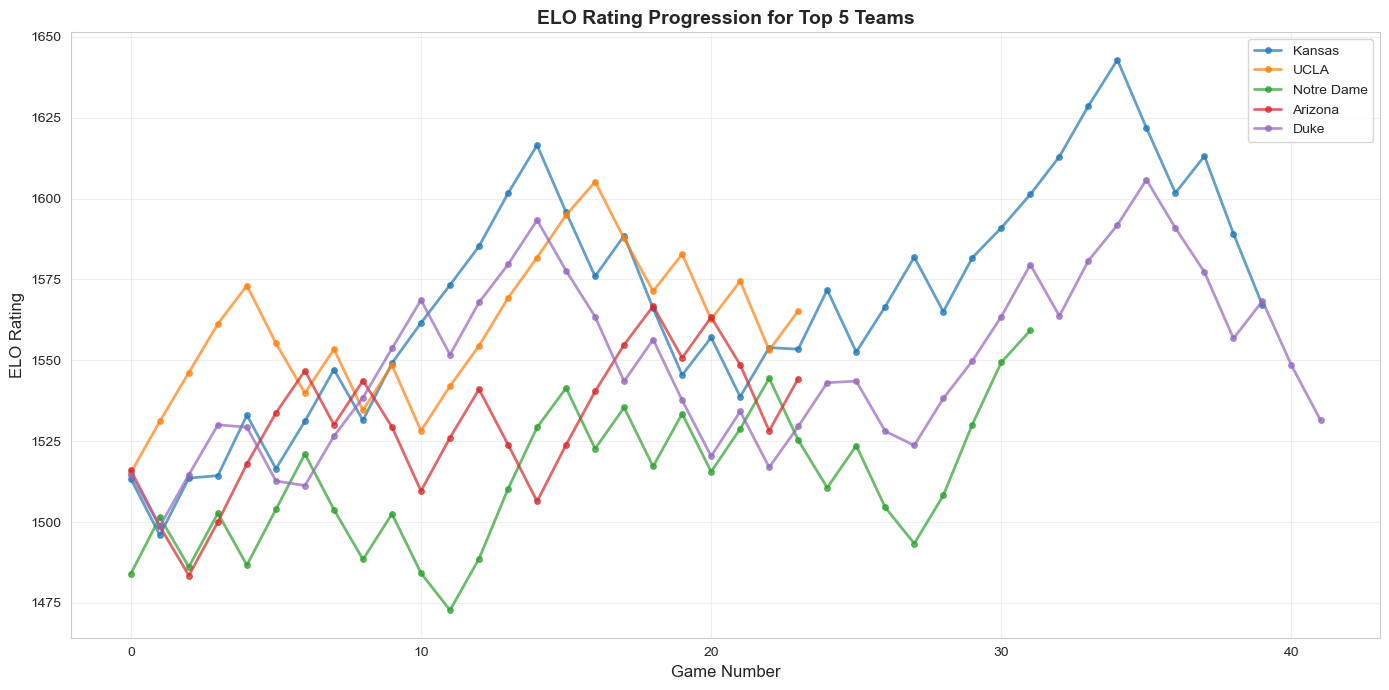

Chart shows how top-rated teams' ELO ratings changed throughout the season.


In [9]:
# Track ratings over time for top teams
history_df = elo_model.get_history_dataframe()

# Get top 5 final teams
top_5_teams = final_rankings.head(5)['team'].tolist()

# Create a plot showing rating progression
fig, ax = plt.subplots(figsize=(14, 7))

for team in top_5_teams:
    team_history = history_df[history_df['team'] == team].reset_index(drop=True)
    team_history['game_num'] = range(len(team_history))
    ax.plot(team_history['game_num'], team_history['new_rating'], 
            marker='o', label=team, linewidth=2, markersize=4, alpha=0.7)

ax.set_xlabel('Game Number', fontsize=12)
ax.set_ylabel('ELO Rating', fontsize=12)
ax.set_title('ELO Rating Progression for Top 5 Teams', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Chart shows how top-rated teams' ELO ratings changed throughout the season.")

## 8. Analyze Rating Distributions

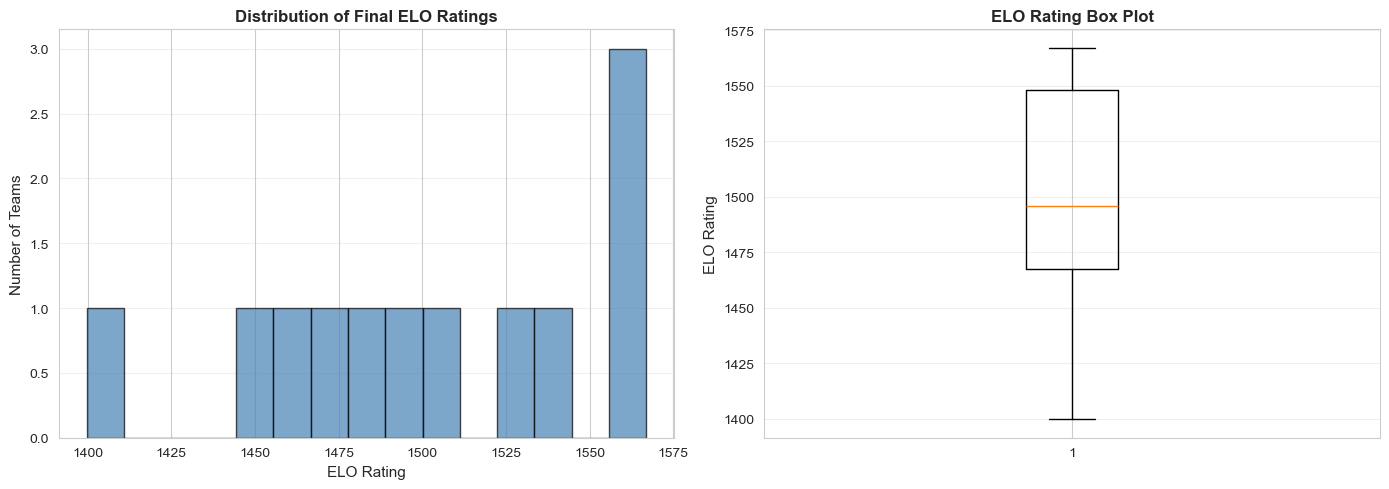

Final Rating Distribution Statistics:
Mean: 1502.5
Median: 1495.7
Std Dev: 50.0
Min: 1399.7
Max: 1567.0
Range: 167.3


In [10]:
# Analyze distribution of final ratings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ratings = final_rankings['rating'].values
axes[0].hist(ratings, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('ELO Rating', fontsize=11)
axes[0].set_ylabel('Number of Teams', fontsize=11)
axes[0].set_title('Distribution of Final ELO Ratings', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot
axes[1].boxplot(ratings, vert=True)
axes[1].set_ylabel('ELO Rating', fontsize=11)
axes[1].set_title('ELO Rating Box Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("Final Rating Distribution Statistics:")
print(f"Mean: {ratings.mean():.1f}")
print(f"Median: {np.median(ratings):.1f}")
print(f"Std Dev: {ratings.std():.1f}")
print(f"Min: {ratings.min():.1f}")
print(f"Max: {ratings.max():.1f}")
print(f"Range: {ratings.max() - ratings.min():.1f}")

## 9. Export Results and Rankings

In [11]:
# Export final rankings to CSV
output_dir = '../data'
import os
os.makedirs(output_dir, exist_ok=True)

final_rankings.to_csv(f'{output_dir}/final_elo_rankings.csv', index=False)
history_df.to_csv(f'{output_dir}/rating_history.csv', index=False)

print("✓ Exported final_elo_rankings.csv")
print("✓ Exported rating_history.csv")

print("\nFinal Rankings Summary:")
print(final_rankings.to_string(index=False))

# Show statistics by rank quartile
print("\n\nRatings by Quartile:")
quantiles = [0.25, 0.5, 0.75]
for q in quantiles:
    val = final_rankings['rating'].quantile(q)
    print(f"{q:.0%} quartile: {val:.1f}")

✓ Exported final_elo_rankings.csv
✓ Exported rating_history.csv

Final Rankings Summary:
 rank           team      rating
    1         Kansas 1566.996928
    2           UCLA 1565.306693
    3     Notre Dame 1559.265676
    4        Arizona 1544.355069
    5           Duke 1531.503626
    6        Indiana 1501.393833
    7        Gonzaga 1490.085103
    8          Texas 1486.074578
    9      Wisconsin 1468.669168
   10      Villanova 1462.856649
   11 North Carolina 1453.644754
   12       Michigan 1399.730855


Ratings by Quartile:
25% quartile: 1467.2
50% quartile: 1495.7
75% quartile: 1548.1
